## Quantitative agents

In this small part of notebook, I'll introduce quantitative agent with step-by-step manner.

## Setup

### Setup paths

* Add necessary imports for Google Drive which will be the working directory.
* Change the paths according to where your dataset is.

In [ ]:
from google.colab import drive
import sys, os

#mount google drive
drive.mount('/content/drive', force_remount=False)
# Change folder path so it corresponds to your environment
#COLAB_PATH = '/content/drive/My Drive/'
# change directory to the path above
#os.chdir(COLAB_PATH)

Mounted at /content/drive


### Install libraries

Install relevant libraries.

In [ ]:
!pip install yfinance
!pip install pandas_datareader
!pip install pymysql

     |████████████████████████████████| 6.3 MB 5.9 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=084dc4c163b9bcad55bbf7eb26de60b52a7b691b0cd7e640283c12f11c9bc681
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
     |████████████████████████████████| 43 kB 1.2 MB/s 


### Import libraries

In [ ]:
#libraries for general purpose
import requests
import numpy as np
import pandas as pd
import pandas as pd
import seaborn as sns
import time
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import itertools
import calendar
import warnings
import json
import seaborn as sns
from sqlalchemy import create_engine
warnings.filterwarnings(action='ignore')

### Create sql alchemy engine

It is used to establish the access to the NUS data library. Regarding NUS data library, please ask to Reshma who is the manager of the database. About the details, pls ask to the administrator of data library at Fintech Lab.

In [ ]:
# create sqlalchemy engine
sqlEngine = create_engine("mysql+pymysql://{user}:{pw}@{host}:{port}/{db}"
                       .format(user="xxxxxx",
                               pw="xxxxxx",
                               db="xxxxxx",
                               host = 'xxx.xxx.xxx.xxx',
                               port = xxxxx))

## Taking a part of Broker agent (Only for price acquisition purpose)

In [ ]:
class Broker(object):

  #get whole price from SQL data library.
  @staticmethod
  def getPriceFromDataLibrary():
    dbConnection = sqlEngine.connect()
    price_df = pd.read_sql("select * from YahooData", dbConnection)
    dbConnection.close()

    price_df = price_df.set_index('Date')[['Close','Volume']]
    price_df.columns = ['close','volume']
    return price_df

  @staticmethod
  def addPctChg(df):
    df = df.copy()
    #calculate % changes
    df['pct_change'] = df['close'].pct_change()
    #In the backtesting, log return is useful, because we can calculate accumulate return %
    #just by adding daily return %. np.log1p calculate log(1+x)
    df['log_return'] = np.log1p(df['pct_change'])

    return df

  @staticmethod
  def histPriceAcquisition():
    longhist_price_df = Broker.getPriceFromDataLibrary()
    #add pct change and log_return
    longhist_price_df = Broker.addPctChg(longhist_price_df)

    #assure all 365 days are within the data index.
    startday = longhist_price_df.index[0]
    endday = longhist_price_df.index[-1]

    date_index = pd.date_range(start = startday, end = endday, freq="D").strftime('%Y-%m-%d')
    date_df = pd.DataFrame(date_index)
    date_df.columns = ['Date']
    date_df['Date'] = pd.to_datetime(date_df['Date']) 
    longhist_price_df = longhist_price_df.reset_index()
    longhist_price_df = date_df.merge(longhist_price_df, on='Date', how='outer')
    #change datetype of Date
    longhist_price_df['Date'] = longhist_price_df['Date'].astype("datetime64")
    #executing ffill (if no price is available, just filling by previous price data)
    longhist_price_df = longhist_price_df.fillna(method='ffill')
    longhist_price_df = longhist_price_df.set_index('Date')

    #Broker.longhist_price_df is created under Broker class.
    Broker.longhist_price_df = longhist_price_df[['close','volume','pct_change','log_return']]

  ########################
  #Getter functions
  ########################

  #Those can become interface
  #for communication among
  #different agents
  @staticmethod
  def longHistoryPriceGetter():
    return Broker.longhist_price_df

In [ ]:
Broker.histPriceAcquisition()

In [ ]:
Broker.longHistoryPriceGetter().head()

,close,volume,pct_change,log_return
Date,,,,
2014-09-17,457.334015,21056800.0,NaN,NaN
2014-09-18,424.440002,34483200.0,-0.071926,-0.074643
2014-09-19,394.795990,37919700.0,-0.069843,-0.072402
2014-09-20,408.903992,36863600.0,0.035735,0.035111
2014-09-21,398.821014,26580100.0,-0.024659,-0.024968


## Explanation and guide for Quantitative agents

As a quantitative signaling agent, I implemented two different trading strategies, using different technical indicators. One is SMA crossover strategy, and the other is Bollinger bands strategy.

### Simple Moving Average (SMA)

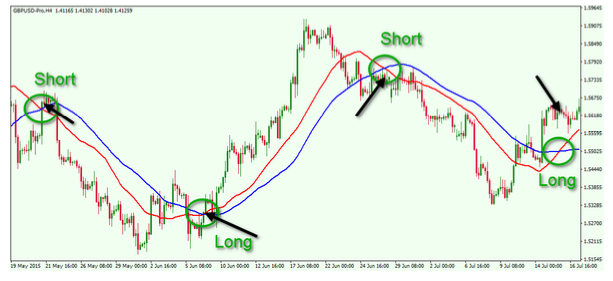

(Source: https://forextraininggroup.com/anatomy-of-popular-moving-averages-in-forex/)

* **Simple Moving Average (SMA)**
 
 SMA is one of the most popular and common technical indicators in the technical analysis field. SMA is the average price over a given number of time periods. Then, we defined the golden-cross and death-cross.

* **Golden cross**

 The golden-cross occurs when the short-term moving average (short-term MA) price goes over long-term moving average (long-term MA) to the upside and is interpreted as buying opportunities.

* **Death cross**

 Similarly downside moving average crossover constitutes the death-cross and is understood to signal a downturn in a market.
 
* **Popular Trend-following strategy**
 
 - SMA trading strategy is recognized as one of the most popular “trend-following strategies”. Trend-following strategy can perform well if the underlying asset class often shows strong and long-term upward and downward trends.
 - On the other hand, trend-following strategies can perform poorly if the market is within a narrow range i.e. consolidation. Daily trading signal data can be stored at the dataframe of self.agent1_hist_signal_df, and the decider agent will receive trading signal data from this dataframe.

Note:

To achieve versatility i.e. for the back-testing agent can calculate past return and risk not only for SMA agent but also for any other style of quantitative / qualitative agents, each signaling agents need to create below columns and pass those to back-testing agent:

* "long-signal" = [1(=start buying), 0(=do nothing/continue current long position), -1(=exit from current long position)]

* "short-signal" = [1(=start shorting), 0(=do nothing/continue current short position), -1(=exit from current short position)]

### Bollinger Bands

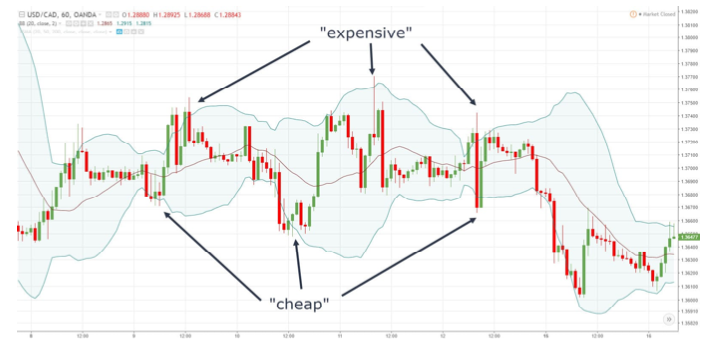

(Source:https://www.tradingwithrayner.com/bollinger-bands-trading-strategy/)

* **Bollinger Bands**
 - Bollinger Bands® are a technical analysis tool developed by John Bollinger for generating oversold or overbought signals.
 - There are three lines that compose Bollinger Bands: A simple moving average (middle band) and an upper and lower band. The upper and lower bands are typically 2 standard deviations +/- from a 20-day simple moving average, but can be modified.

* **Logic of Bollinger Bands**

  - If the price goes up beyond the upper band, it is recognized as expensive such that it is a “sell” opportunity.
  - As opposed, if the price goes down below the lower band, it is recognized as cheap such that it is a “buy” opportunity.
  - We can set exit rules differently. For example, many practitioners set exit points when the price reverts back to the moving average. Or, we can also set exit points when the price reverts back between upper and lower bands. The system applies the latter rule for the exit.

* **Mean-reversion strategy**

 As you can see, the above trading rule is based on the assumption of “mean reversion”, i.e. after the price goes up extremely it can go down and vice versa. Hence, this strategy can work well, when the market is in range bound i.e. in consolidation. On the other hand, when there exists a strong and long-term upward or downward trend, such a mean-reverting strategy cannot work well.


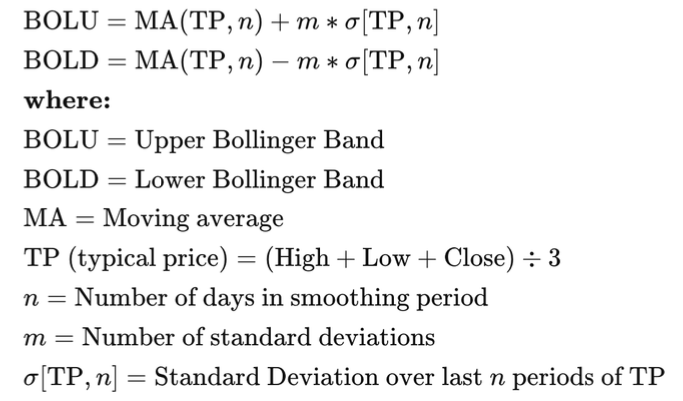

(Source: https://www.investopedia.com/trading/using-bollinger-bands-to-gauge-trends/)

* Above formulas are the formal notation of bollinger bands. In practice, TP can be simplified just by close price, such that the system applies this practically simple approach.

* In the back-test optimization, the system implements greedy search from the search space of n = [10, 20] and m = [2.0, 3.0].

* Daily trading signal data can be stored at the dataframe of self.agent2_hist_signal_df, and the decider agent will receive trading signal data from this dataframe.


## Whole code of the agent

In [ ]:
class quantsSignal():

  #initialization.
  #backtest=False: day-to-day trading
  #backtest=True: signal for backtest
  def __init__(self,backtest=False):
    self.agent1_hist_signal_df = pd.DataFrame()
    self.agent2_hist_signal_df = pd.DataFrame()
    self.backtest = backtest

  #Function to create moving average.
  def movingAvg(self,df,day, short_term, long_term):
    #rolling short-term moving average
    df['ma_short'] = df['close'].rolling(window=short_term).mean()
    #rolling long-term moving average
    df['ma_long'] = df['close'].rolling(window=long_term).mean()

    #create signal
    #Golden cross -> Buy signal
    df['long_signal'] = np.where(df['ma_short'] > df['ma_long'], 1, 0)

    #Golden cross -> Buy signal
    df['short_signal'] = np.where(df['ma_short'] < df['ma_long'], 1, 0)

    #output only relevant data
    mvgAvg_df = df.loc[day, ['close','long_signal','short_signal']].to_frame().T
    mvgAvg_df.index.names = ['Date']

    #if no prior data, initialize historical signaling dataframe
    if len(self.agent1_hist_signal_df) == 0:
      self.agent1_hist_signal_df = mvgAvg_df
    #else, update data on historical signaling dataframe
    else:
      self.agent1_hist_signal_df = pd.concat([self.agent1_hist_signal_df,
                                                      mvgAvg_df])

    self.agent1_hist_signal_df = Broker.addPctChg(self.agent1_hist_signal_df)
    #for keeping data cleanness, executing elimination of duplicated day data
    self.agent1_hist_signal_df = self.agent1_hist_signal_df[~self.agent1_hist_signal_df.index.duplicated(keep='first')]

  def movingAvgDailyUpdate(self, day, short_term, long_term):
    tMinus50 = day + datetime.timedelta(days=-50)
    df = Broker.longHistoryPriceGetter().loc[tMinus50:day,:]
    self.movingAvg(df,day, short_term, long_term)

  #Function to create bollinger band.
  def bollingerBand(self, df, day, data_window=20, std_dev=2):
    #rolling x days moving average
    df['ma'] = df['close'].rolling(window=data_window).mean()
    #rolling x days standard deviation
    df['std'] = df['close'].rolling(window=data_window).std()
    #bollinger band lower band: x standard deviation from moving average
    df['low_band'] = df['ma'] - df['std'] * std_dev
    #bollinger band higher band: x standard deviation from moving average
    df['high_band'] = df['ma'] + df['std'] * std_dev

    #create trading signal

    #close price go higher than higher band, it's regarded as overbought,
    #such that it's sell signal.
    df['short_signal'] = np.where(df['close'] > df['high_band'], 1, 0)

    #close price go lower than lower band, it's regarded as oversold,
    #such that it's buy signal.
    df['long_signal'] = np.where(df['close'] < df['low_band'], 1, 0)

    #output only relevant data
    bollinger_df = df.loc[day, ['close','long_signal','short_signal']].to_frame().T
    bollinger_df.index.names = ['Date']

    #if no prior data, initialize historical signaling dataframe
    if len(self.agent2_hist_signal_df) == 0:
      self.agent2_hist_signal_df = bollinger_df
    #else, update data on historical signaling dataframe
    else:
      self.agent2_hist_signal_df = pd.concat([self.agent2_hist_signal_df,
                                                      bollinger_df])
      
    self.agent2_hist_signal_df = Broker.addPctChg(self.agent2_hist_signal_df)
    #for keeping data cleanness, executing elimination of duplicated day data
    self.agent2_hist_signal_df = self.agent2_hist_signal_df[~self.agent2_hist_signal_df.index.duplicated(keep='first')]

  def bollingerDailyUpdate(self, day, data_window=20, std_dev=2):
    tMinus50 = day + datetime.timedelta(days=-50)
    df = Broker.longHistoryPriceGetter().loc[tMinus50:day,:]
    self.bollingerBand(df, day, data_window, std_dev)

  ########################
  #Getter functions
  #Those can become interface
  #for communication among
  #different agents
  ########################
  def agent1SignalGetter(self):
    return self.agent1_hist_signal_df

  def agent2SignalGetter(self):
    return self.agent2_hist_signal_df

## Dissection of the agent

### Set up

In [ ]:
#create dataframes for storing buy/sell signals
agent1_hist_signal_df = pd.DataFrame()
agent2_hist_signal_df = pd.DataFrame()

In [ ]:
#obtaining price of bitcoin using Broker agent
price_df = Broker.longHistoryPriceGetter()

In [ ]:
price_df.head()

,close,volume,pct_change,log_return
Date,,,,
2014-09-17,457.334015,21056800.0,NaN,NaN
2014-09-18,424.440002,34483200.0,-0.071926,-0.074643
2014-09-19,394.795990,37919700.0,-0.069843,-0.072402
2014-09-20,408.903992,36863600.0,0.035735,0.035111
2014-09-21,398.821014,26580100.0,-0.024659,-0.024968


### Simple Moving Average (SMA) signal

In [ ]:
df = price_df.copy()

In [ ]:
#set parameter
short_term = 5
long_term = 20

In [ ]:
#rolling short-term moving average
df['ma_short'] = df['close'].rolling(window=short_term).mean()
#rolling long-term moving average
df['ma_long'] = df['close'].rolling(window=long_term).mean()

In [ ]:
df.tail()

,close,volume,pct_change,log_return,ma_short,ma_long
Date,,,,,,
2021-08-13,47793.320312,3.174426e+10,0.075741,0.073009,45953.135938,41742.185547
2021-08-14,47096.945312,3.121135e+10,-0.014571,-0.014678,46099.444531,42329.523438
2021-08-15,47047.003906,3.098896e+10,-0.001060,-0.001061,46391.839063,42814.996875
2021-08-16,46004.484375,3.277688e+10,-0.022159,-0.022408,46474.008594,43144.874023
2021-08-17,44695.359375,3.345136e+10,-0.028456,-0.028869,46527.422656,43379.846680


In [ ]:
#create signal
#Golden cross -> Buy signal
df['long_signal'] = np.where(df['ma_short'] > df['ma_long'], 1, 0)
#Death cross -> Sell signal
df['short_signal'] = np.where(df['ma_short'] < df['ma_long'], 1, 0)

In [ ]:
df.tail()

,close,volume,pct_change,log_return,ma_short,ma_long,long_signal,short_signal
Date,,,,,,,,
2021-08-13,47793.320312,3.174426e+10,0.075741,0.073009,45953.135938,41742.185547,1,0
2021-08-14,47096.945312,3.121135e+10,-0.014571,-0.014678,46099.444531,42329.523438,1,0
2021-08-15,47047.003906,3.098896e+10,-0.001060,-0.001061,46391.839063,42814.996875,1,0
2021-08-16,46004.484375,3.277688e+10,-0.022159,-0.022408,46474.008594,43144.874023,1,0
2021-08-17,44695.359375,3.345136e+10,-0.028456,-0.028869,46527.422656,43379.846680,1,0


In [ ]:
mvgAvg_df = df.loc[:, ['close','long_signal','short_signal']]

#if no prior data, initialize historical signaling dataframe
if len(agent1_hist_signal_df) == 0:
  agent1_hist_signal_df = mvgAvg_df
#else, update data on historical signaling dataframe
else:
  agent1_hist_signal_df = pd.concat([agent1_hist_signal_df,
                                                  mvgAvg_df])

agent1_hist_signal_df = Broker.addPctChg(agent1_hist_signal_df)
#for keeping data cleanness, executing elimination of duplicated day data
agent1_hist_signal_df = agent1_hist_signal_df[~agent1_hist_signal_df.index.duplicated(keep='first')]

In [ ]:
agent1_hist_signal_df

,close,long_signal,short_signal,pct_change,log_return
Date,,,,,
2014-09-17,457.334015,0,0,NaN,NaN
2014-09-18,424.440002,0,0,-0.071926,-0.074643
2014-09-19,394.795990,0,0,-0.069843,-0.072402
2014-09-20,408.903992,0,0,0.035735,0.035111
2014-09-21,398.821014,0,0,-0.024659,-0.024968
...,...,...,...,...,...
2021-08-13,47793.320312,1,0,0.075741,0.073009
2021-08-14,47096.945312,1,0,-0.014571,-0.014678
2021-08-15,47047.003906,1,0,-0.001060,-0.001061


### Bollinger Bands signal

In [ ]:
#set parameters
data_window=20
std_dev=2

In [ ]:
df2 = price_df

In [ ]:
#rolling x days moving average
df2['ma'] = df2['close'].rolling(window=data_window).mean()
#rolling x days standard deviation
df2['std'] = df2['close'].rolling(window=data_window).std()
#bollinger band lower band: x standard deviation from moving average
df2['low_band'] = df2['ma'] - df2['std'] * std_dev
#bollinger band higher band: x standard deviation from moving average
df2['high_band'] = df2['ma'] + df2['std'] * std_dev

In [ ]:
df2

,close,volume,pct_change,log_return,ma,std,low_band,high_band
Date,,,,,,,,
2014-09-17,457.334015,2.105680e+07,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-18,424.440002,3.448320e+07,-0.071926,-0.074643,NaN,NaN,NaN,NaN
2014-09-19,394.795990,3.791970e+07,-0.069843,-0.072402,NaN,NaN,NaN,NaN
2014-09-20,408.903992,3.686360e+07,0.035735,0.035111,NaN,NaN,NaN,NaN
2014-09-21,398.821014,2.658010e+07,-0.024659,-0.024968,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2021-08-13,47793.320312,3.174426e+10,0.075741,0.073009,41742.185547,3303.324488,35135.536571,48348.834523
2021-08-14,47096.945312,3.121135e+10,-0.014571,-0.014678,42329.523438,3147.627327,36034.268784,48624.778091
2021-08-15,47047.003906,3.098896e+10,-0.001060,-0.001061,42814.996875,3085.318236,36644.360403,48985.633347


In [ ]:
#close price go higher than higher band, it's regarded as overbought,
#such that it's sell signal.
df2['short_signal'] = np.where(df2['close'] > df2['high_band'], 1, 0)

#close price go lower than lower band, it's regarded as oversold,
#such that it's buy signal.
df2['long_signal'] = np.where(df2['close'] < df2['low_band'], 1, 0)

In [ ]:
#output only relevant data
bollinger_df = df2.loc[:, ['close','long_signal','short_signal']]
bollinger_df.index.names = ['Date']

In [ ]:
#if no prior data, initialize historical signaling dataframe
if len(agent2_hist_signal_df) == 0:
  agent2_hist_signal_df = bollinger_df
#else, update data on historical signaling dataframe
else:
  agent2_hist_signal_df = pd.concat([agent2_hist_signal_df,
                                                  bollinger_df])
  
agent2_hist_signal_df = Broker.addPctChg(agent2_hist_signal_df)
#for keeping data cleanness, executing elimination of duplicated day data
agent2_hist_signal_df = agent2_hist_signal_df[~agent2_hist_signal_df.index.duplicated(keep='first')]

In [ ]:
agent2_hist_signal_df

,close,long_signal,short_signal,pct_change,log_return
Date,,,,,
2014-09-17,457.334015,0,0,NaN,NaN
2014-09-18,424.440002,0,0,-0.071926,-0.074643
2014-09-19,394.795990,0,0,-0.069843,-0.072402
2014-09-20,408.903992,0,0,0.035735,0.035111
2014-09-21,398.821014,0,0,-0.024659,-0.024968
...,...,...,...,...,...
2021-08-13,47793.320312,0,0,0.075741,0.073009
2021-08-14,47096.945312,0,0,-0.014571,-0.014678
2021-08-15,47047.003906,0,0,-0.001060,-0.001061


(Note: To use signal data to check how PnL and backtesting agents work, we save those result with csv files.)

In [ ]:
agent1_hist_signal_df.to_csv('signal_files/agent1_hist_signal_df.csv')

In [ ]:
agent2_hist_signal_df.to_csv('signal_files/agent2_hist_signal_df.csv')